### TODO:
Girish
- ~~Dataset construction~~

Mike
- ~~implement build_sequences & build_skipgrams~~
- ~~softmax word embeddings~~
- implement to_onehot_tensor
- seq2seq autoencoder
- train noise-contrastive word embeddings

Guowei
- clustering & metrics
- low dimensional PCA / MDN / TSNE visualizations

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import collections
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline
plt.style.use('ggplot')

In [2]:
data = pd.DataFrame.from_csv('./modeling_data.tsv', sep='|')
subj = 'sequence_table.subject_id'
hadm = 'sequence_table.hadm_id'
service = 'sequence_table.service'
exp = 'sequence_table.expire_flag'
seq = 'sequence_table.icd_seq'
data.reset_index(inplace=True)
data.set_index([subj, hadm, service], inplace=True)
sequences = data[seq].sample(1000)

/Users/mwalton/miniconda3/envs/gatech/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


In [186]:
def filter_sequences(series, vocab_size=None, min_seq_len=0, max_seq_len=float('Inf')):
    ''' This function accepts a pandas Series object and filteres it by the following args:
        vocab_size: drops tokens that occur with frequency less than the top vocab_size
                    tokens in the dictionary
        min_seq_len: drop sequences with less than min_seq_len
        max_seq_len: truncate sequences longer than max_seq_len
        
        Returns:
        filtered_batch: list of tokenized sequence lists
        counts: token frequencies
        lengths: length of each sequence after filter
        '''
    max_len = 0
    batch = []
    counts = collections.Counter()
    
    for key, val in series.iteritems():
        v = [int(x) for x in val.split(',')]
        
        if len(v) < min_seq_len:
            continue
        if len(v) > max_seq_len:
            v = v[:max_seq_len]
        counts += collections.Counter(v)
        batch.append(v)
    
    if vocab_size != None:
        counts = collections.Counter(dict(counts.most_common(vocab_size)))
        
    dictionary = dict()
    
    for word, _ in list(counts.items()):
        dictionary[word] = len(dictionary)
        
    inverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    filtered_batch = []
    lengths = []
    
    for s in batch:
        s_ = [dictionary[x] for x in s if x in dictionary]
        
        # edge case handling, infrequent token filter pushes seq len below min
        if len(s_) < min_seq_len:
            counts -= collections.Counter(s_)
            continue
        
        filtered_batch.append(s_)
        lengths.append(len(s_))
    
    return filtered_batch, counts, lengths, dictionary, inverse_dictionary

In [187]:
_, counts_raw, lengths_raw, _, _ = filter_sequences(sequences)
batch, counts, lengths, icd2idx, idx2icd = filter_sequences(sequences,
                                                           vocab_size=500,
                                                           min_seq_len=250,
                                                           max_seq_len=500)

Text(0.5,1,'Filtered Sequence Lengths')

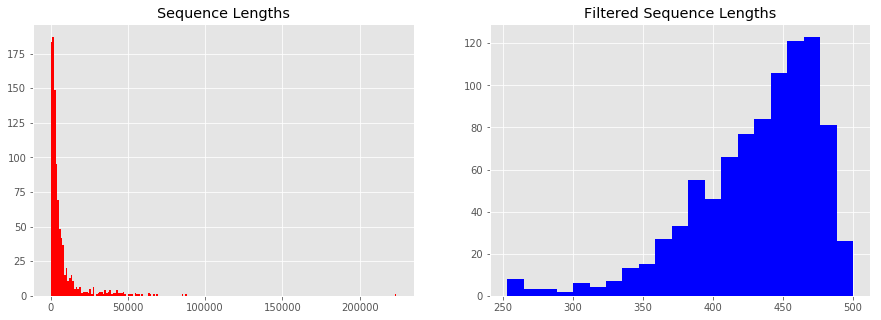

In [188]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.hist(lengths_raw, color='r', bins='auto')
ax1.set_title("Sequence Lengths")
ax2.hist(lengths, color='b', bins='auto')
ax2.set_title("Filtered Sequence Lengths")

Text(0.5,1,'Filtered Event Counts')

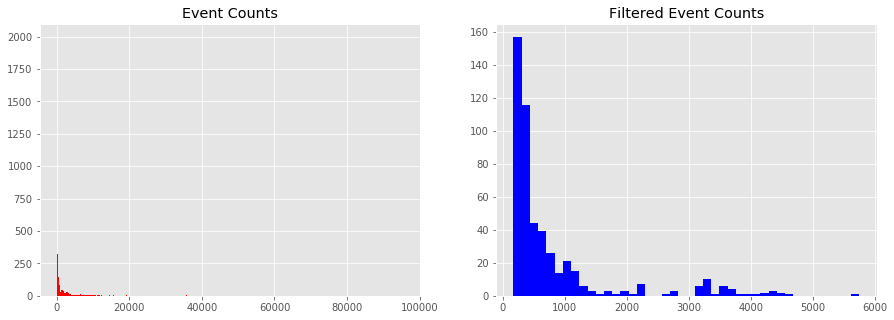

In [189]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.hist([c for i, c in counts_raw.items()], color='r', bins='auto')
ax2.hist([c for i, c in counts.items()], color='b', bins='auto')
ax1.set_title("Event Counts")
ax2.set_title("Filtered Event Counts")

# Skip-Gram Word Embeddings

In [190]:
def to_one_hot(vocab_size):
    def f(idx):
        zeros = np.zeros(vocab_size)
        zeros[idx] = 1
        return zeros

    return f

def build_skipgrams(sequences, vocab_size, one_hot=False):
    ''' This constructs simple skip grams,
    assumes max 2 skips per word; skip window of one.
    For every word x, produce two y = neighbors(x).
    both x_train and y_train will be matricies with shape (n, d)
    where d is the size of the vocabulary and n is resultant sample size'''
    data = []
    for seq in sequences:
        for i in range(len(seq) - 1):
            data.append((seq[i], seq[i + 1]))
            data.append((seq[i + 1], seq[i]))

    if one_hot:
        vectorize = to_one_hot(vocab_size)
        x_train = []
        y_train = []

        for d in data:
            x_train.append(vectorize(d[0]))
            y_train.append(vectorize(d[1]))
        x_train = np.asarray(x_train)
        y_train = np.asarray(y_train)

    else:
        x_train = np.asarray(data)[:, 0]
        y_train = np.asarray(data)[:, 1]

    return x_train, y_train

## Maximum Likelihood Estimation

In [251]:
vocab_size = len(counts)
x_train, y_train = build_skipgrams(batch, vocab_size, one_hot=True)

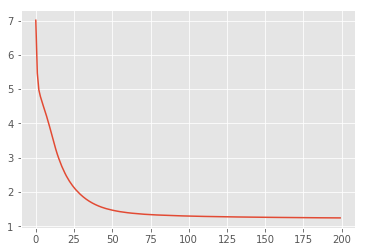

In [233]:
embedding_dim = 32

x = tf.keras.layers.Input(shape=(vocab_size,))
embedding = tf.keras.layers.Dense(embedding_dim)(x)
y_pred = tf.keras.layers.Dense(vocab_size, activation='softmax')(embedding)
model = tf.keras.models.Model(x, y_pred)
model.compile(optimizer='adam', loss='categorical_crossentropy')

hist = model.fit(x_train[:1000], y_train[:1000],
                 batch_size=64,
                 epochs=200,
                verbose=0)

plt.plot(hist.history['loss'])

In [229]:
embed = tf.keras.models.Model(x, embedding)

train_idx = range(1000)#np.random.randint(0, x_train.shape[0], 1000)
x_embed = embed.predict(x_train[train_idx])

In [230]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=250)
low_dim_embeds = tsne.fit_transform(x_embed)

In [231]:
rescaled = StandardScaler().fit_transform(x_embed)
db = DBSCAN(eps=.15, min_samples=10).fit(rescaled)
labels = db.labels_
silhouette = silhouette_score(rescaled, labels) if len(np.unique(db.labels_)) > 1 else 0.0

print("NB clusters: ", len(np.unique(labels)))
print("Silhouette Score: {}".format(silhouette))

NB clusters:  26
Silhouette Score: 0.3945351541042328


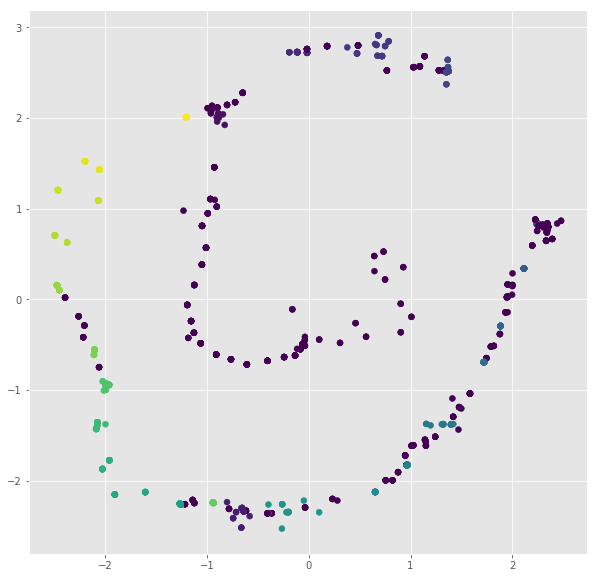

In [232]:
plt.figure(figsize=(10,10))
plt.scatter(low_dim_embeds[:,0], low_dim_embeds[:,1], c=labels)

## Noise Contrastive Estimation

In [238]:
vocab_size = len(counts)
x_train, y_train = build_skipgrams(batch, vocab_size, one_hot=False)

In [ ]:
embedding_dim = 32
num_sampled = 64 # Noise samples per positive example

x = tf.keras.layers.Input(shape=(None,))
embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)(x)


y_pred = tf.keras.layers.Dense(vocab_size, activation='softmax')(embedding)
model = tf.keras.models.Model(x, y_pred)
model.compile(optimizer='adam', loss='categorical_crossentropy')

hist = model.fit(x_train[:100], y_train[:100],
                 batch_size=64,
                 epochs=200,
                verbose=0)

plt.plot(hist.history['loss'])


#####################################
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.int32, shape=(batch_size))
    y = tf.placeholder(tf.int32, shape=(batch_size, 1))

    e_params = tf.Variable(tf.random_uniform([vocab_size + 1, embedding_dim], -1.0, 1.0))
    embedding = tf.nn.embedding_lookup(e_params, x)

    W = tf.Variable(tf.truncated_normal([vocab_size + 1], stddev=1.0 / np.sqrt(embedding_dim)))
    b = tf.Variable(tf.zeros([vocab_size + 1]))
    
    tf.keras.losses.

    loss = tf.reduce_mean(tf.nn.nce_loss(W, b, labels=y,
                                         inputs=embedding,
                                         num_sampled=num_sampled,
                                         num_classes=vocab_size+1))

    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    init = tf.global_variables_initializer()

# Seq2Seq Autoencoder Embedding

In [247]:
def to_onehot_tensor(sequences, vocab_size, maxlen):
    ''' Maps a list of N lists with arbitrary length 
    to a tensor with shape (N, vocab_size, maxlen)'''
    onehot_tensor = np.zeros((len(sequences), vocab_size, maxlen))
    
    for i, seq in enumerate(sequences):
        for j, idx in enumerate(seq):
            onehot_tensor[i,idx,j] = 1.0

    return onehot_tensor, onehot_tensor

In [258]:
vocab_size = len(counts)
maxlen = max(lengths)

x_train, y_train = to_onehot_tensor(batch, vocab_size, maxlen)

In [262]:
model.count_params()

1260524

In [261]:
embedding_dim = 2
hidden_dim = 32

x = tf.keras.layers.Input(shape=(vocab_size, maxlen))
encoder = tf.keras.layers.LSTM(embedding_dim)(x)
embedding = tf.keras.layers.RepeatVector(maxlen)(encoder)
decoder = tf.keras.layers.LSTM(vocab_size, return_sequences=True)(embedding)
y_pred = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder)
model = tf.keras.models.Model(x, y_pred)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# hist = model.fit(x_train[:100], y_train[:100],
#                  batch_size=64,
#                  epochs=200,
#                 verbose=0)

# plt.plot(hist.history['loss'])

## 